In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_auc_score,plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport


In [2]:
pwd

'/Users/andrewstephens/Final_project/Modeling'

In [3]:
cd ..

/Users/andrewstephens/Final_project


In [4]:
df = pd.read_csv('Data/Preprocessing.csv',index_col=0)
df.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y,job_admin.,job_blue-collar,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,93.994,-36.4,5191.0,no,1,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0


# Making Sure Data is Balanced 



We will be using the undersampling strategy, however,we first must break df into X and y to then split again into test and train sets. 

In [5]:
X=df.drop(['y',"y_yes","y_no"], axis=1)
y=df['y']



In [6]:
# summarize class distribution

print("Before undersampling: ", Counter(y))
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='all')

# fit and apply the transform
X, y = undersample.fit_resample(X, y)


# summarize class distribution

print("After undersampling: ", Counter(y))

Before undersampling:  Counter({'no': 36548, 'yes': 4640})
After undersampling:  Counter({'no': 4640, 'yes': 4640})


In [7]:
print(Counter(y))

Counter({'no': 4640, 'yes': 4640})


In [8]:
# Looks like our data is balanced

# Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [10]:
# normalize data 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [11]:
X_train.shape, y_train.shape 

((7424, 60), (7424,))

In [12]:
print(y_train)

1423     no
7755    yes
1131     no
496      no
3201     no
       ... 
2895     no
7813    yes
905      no
5192    yes
235      no
Name: y, Length: 7424, dtype: object


# Model Creation

We will be starting with KNN, a unsupervised learning method, because its versatile, simple, accurate and non assumpitve. Choosing K parameter will be most important, as it may cause overfitting if we are not careful. 

# KNN 

In [13]:
# pipeline combining transformers and estimator
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())

In [14]:
# grid searh to choose the best (combination of) hyperparameters
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=5)


In [15]:



# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_knn_scores = cross_val_score(gs_knn, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)



In [16]:
# fit, and fit with best estimator
gs_knn.fit(X_train, y_train)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [17]:
print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(X_test, y_test)*100))


Train Accuracy:   76.3%
Test Accuracy:    70.8%


In [18]:
#confusion_matrix and classification report
ypreds=gs_knn_best.predict(X_test)
print(classification_report(y_test,ypreds))



              precision    recall  f1-score   support

          no       0.68      0.79      0.73       923
         yes       0.75      0.63      0.68       933

    accuracy                           0.71      1856
   macro avg       0.71      0.71      0.71      1856
weighted avg       0.71      0.71      0.71      1856



In [19]:
#confusion matrix 

Confusion matrix, without normalization
[[730 193]
 [349 584]]
Normalized confusion matrix
[[0.79089924 0.20910076]
 [0.37406217 0.62593783]]


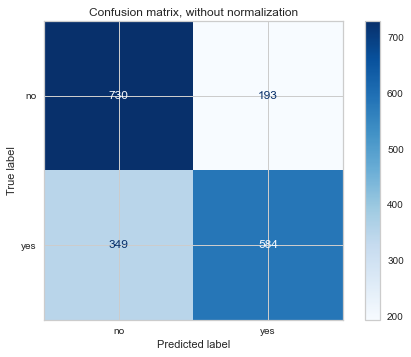

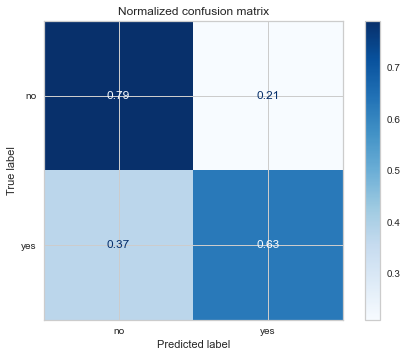

In [20]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


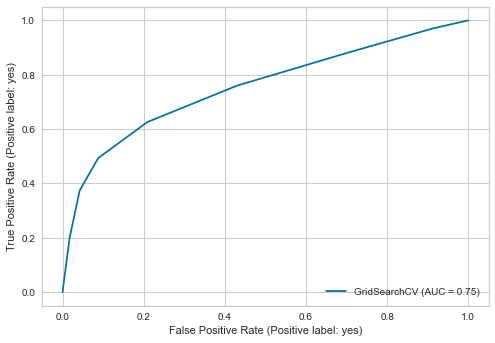

In [21]:
KNN_score = plot_roc_curve(gs_knn, X_test, y_test)

37% FP and 21%FN, AUC 75%

Looks really good ! Now lets try Logistic Regression. 

# Logistic Regression 

In [22]:
lr = LogisticRegressionCV(random_state=1, max_iter =1000)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [23]:
test_accuracy = accuracy_score(y_test,preds)
print(test_accuracy)

0.7408405172413793


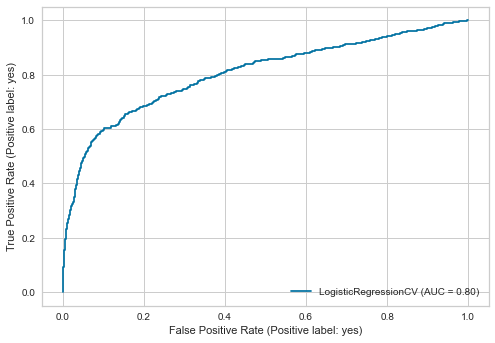

In [24]:
lr_roc = plot_roc_curve(lr, X_test, y_test)

Confusion matrix, without normalization
[[795 128]
 [353 580]]
Normalized confusion matrix
[[0.86132178 0.13867822]
 [0.37834941 0.62165059]]


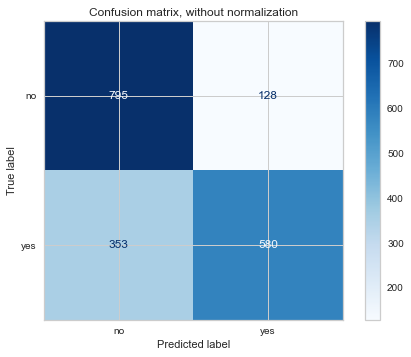

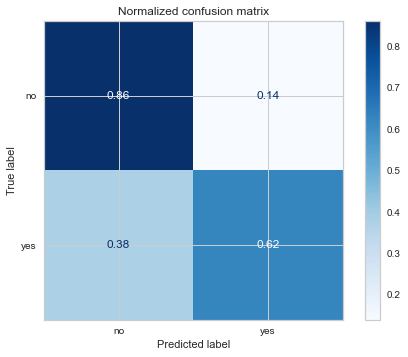

In [25]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


FP 38% FN 14% AUC 80%

# SVM 

A support vector machine is a machine learning model that is able to generalise between two different classes if the set of labelled data is provided in the training set to the algorithm. The main function of the SVM is to check for that hyperplane that is able to distinguish between the two classes.[1]

In [31]:
# pipeline combining transformers and estimator
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1,10]
pg_svm=[ {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=5)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(X_test, y_test)*100))

Train Accuracy:   92.3%
Test Accuracy:    69.7%


In [32]:
#confusion_matrix and classification report
ypreds=gs_svm_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))



[[641 282]
 [281 652]]
              precision    recall  f1-score   support

          no       0.70      0.69      0.69       923
         yes       0.70      0.70      0.70       933

    accuracy                           0.70      1856
   macro avg       0.70      0.70      0.70      1856
weighted avg       0.70      0.70      0.70      1856



Confusion matrix, without normalization
[[641 282]
 [281 652]]
Normalized confusion matrix
[[0.69447454 0.30552546]
 [0.30117899 0.69882101]]


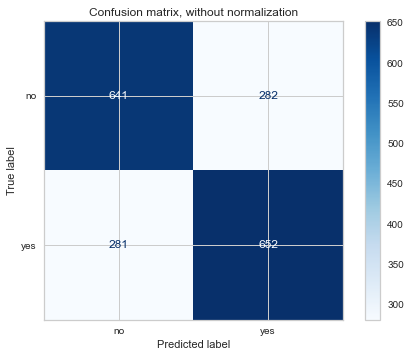

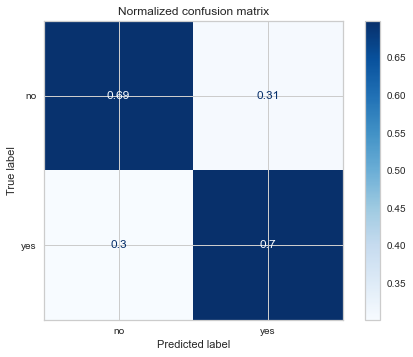

In [33]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_svm, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


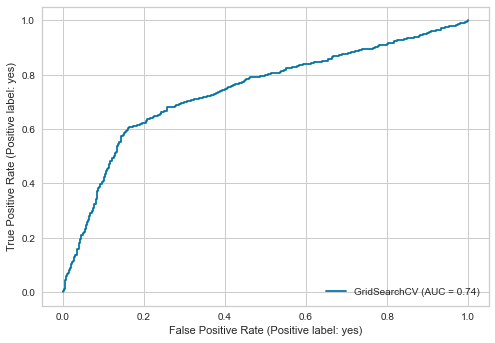

In [34]:
#ROC plot 
svm_plot = plot_roc_curve(gs_svm, X_test, y_test)

FP=29%,FN=32%,AUC=74%

# Random Forest

In [ ]:
rf= RandomForestClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_rf={'n_estimators': [100,400,600],'max_depth': [10,20,40,50,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=5)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_rf_scores = cross_val_score(gs_rf, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_rf.fit(X_train, y_train)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(X_test, y_test)*100))

In [ ]:
#confusion_matrix and classification report
ypreds=gs_rf_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))



In [ ]:
rf_roc = plot_roc_curve(gs_rf, X_test, y_test)

In [ ]:
X_train.shape

In [ ]:
# using random forest to get feature importances
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

It looks like employees plays the biggest factor with how many employees are there to make the calls. 

Age seems to be the biggest factor,but that is no surprise because the younger they can get a client, the longer they can do business with them over the course of their life.Volume is another factor, because we can see how important the number of employees to carry through the campaign is.That means to say that any decrease in the workforce would have negative effects to the marketing campaign. 

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


FP=37,FN=13,AUC =80%

# Gradient Boosting 


In [27]:
# estimator
xb= xgb.XGBClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_xb={'n_estimators':[150,200,400], 'max_depth':[5,10,20,30],'min_child_weight':[.5,.75]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=5)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_xb_scores = cross_val_score(gs_xb, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_xb.fit(X_train, y_train)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(X_test, y_test)*100))


Train Accuracy:   84.4%
Test Accuracy:    73.3%


In [28]:
# using random forest results: confusion_matrix and classification report
ypreds=gs_xb_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))


[[760 163]
 [333 600]]
              precision    recall  f1-score   support

          no       0.70      0.82      0.75       923
         yes       0.79      0.64      0.71       933

    accuracy                           0.73      1856
   macro avg       0.74      0.73      0.73      1856
weighted avg       0.74      0.73      0.73      1856



Confusion matrix, without normalization
[[760 163]
 [333 600]]
Normalized confusion matrix
[[0.82340195 0.17659805]
 [0.35691318 0.64308682]]


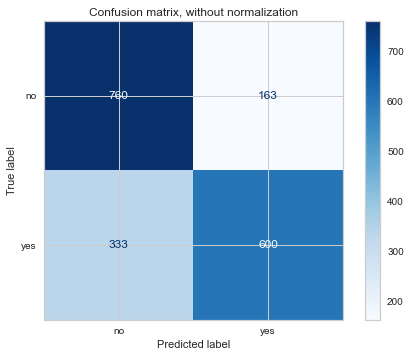

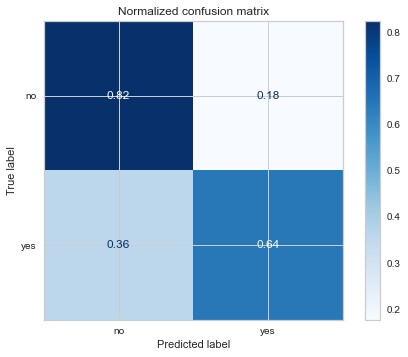

In [29]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_xb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

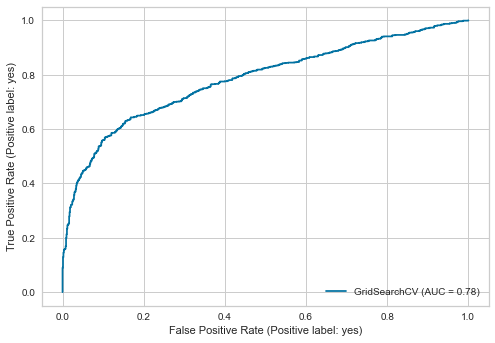

In [30]:
gb_roc = plot_roc_curve(gs_xb, X_test, y_test)

In [ ]:
FP=36,FN=18,AUC=78

the model we choose will be XGboost because the test accuracy is the highest as well as the fp rate being the best 

Reference #1  https://www.analyticssteps.com/blogs/how-does-support-vector-machine-algorithm-works-machine-learning 

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/